# Hypertension DDIs pipeline

Steps to build the pipeline:
1. Useful functions for the pipeline (mapping, retrieving data from web apis...)
2. Find positive and negative controls for the AE of interest
3. Retrieve adverse event report data for these and a set of control drugs
4. Build the training and testing frequency tables
5. Features reduction to avoid overfitting
6. Drugpair predictions
7. Corroboration using OHDSI data

In [172]:
import csv
import gzip
import tqdm
import json
import heapq
import random
import urllib2

import requests
import itertools

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy import stats
from collections import defaultdict
from biothings_client import get_client

from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from urllib2 import Request, urlopen, URLError, build_opener
from json import JSONEncoder

#import OHDSI_API_data_ as ohdsi

%matplotlib inline

In [159]:
from import_notebook import *
sys.meta_path.append(NotebookFinder())
import OHDSI_API_data_ as ohdsi

## Needed functions

In [3]:
ADVERSE_EVENT_OF_INTEREST = 'hypertension'

# adverse events related to hypertension (from SIDER)
AE_LIST = ['hypertension', 'hypertention worsened', 'hypertension paroxysmal']

In [4]:
# Authentication module
# Instructions at https://documentation.uts.nlm.nih.gov/rest/home.html

#get the tgt corresponding to the apikey
def get_tgt(apikey):
    tgt = requests.post("https://utslogin.nlm.nih.gov/cas/v1/api-key", data = {'apikey':apikey})
    TGT = tgt.content.split()[20]
    TGT = TGT[52:+len(TGT)-1]
    return TGT

#get a ticket corresponding to the tgt
def get_ticket(tgt):
    uri_login = "https://utslogin.nlm.nih.gov/cas/v1/tickets/" + tgt
    ticket = requests.post(uri_login, data = {'service':'http://umlsks.nlm.nih.gov'})
    return ticket.content


In [5]:
def AEtoCUI(aeName, apikey):
    "Converts AE name to UMLS CUIs"
    cuis = []
    
    tgt = get_tgt(apikey)
    ticket = get_ticket(tgt)
    
    query = {'ticket':ticket}
    uri = "https://uts-ws.nlm.nih.gov/rest/search/current?string=" + aeName
    r = requests.get(uri, params = query)
    r.encoding = 'utf-8'
    items  = json.loads(r.text)
    
    jsonData = items["result"]
    for s in jsonData['results']:
        cuis.append(s['ui'])
    return cuis

In [29]:
def nsides_api(service, method, args = None):
    """
    Simple python API to access the NSIDES services and data.
    
    service   string, that can be one of three values: aeolus, sider, or omop
    method    string, for a list of methods see http://nsideseb-env.us-east-1.elasticbeanstalk.com
    args      dictionary, method parameters see http://nsideseb-env.us-east-1.elasticbeanstalk.com
    """
    NSIDES_API_URL = 'http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/'
    
    base_url = NSIDES_API_URL + 'query?service=%s&meta=%s' % (service, method)
    url = base_url
    if not args is None:
        url = base_url + '&' + '&'.join(['%s=%s' % (k,v) for k,v in args.items()])
    #print url
    
    response = urllib2.urlopen(url).read()
    data = json.loads(response)
    
    return data

# Test with one value
#reference_byname = list()
#data = nsides_api('sider', 'drugForEffect', {'q': 'C0235750'})
#reference_byname.extend( [(r['drug_name'], 1) for r in data['results']] )
#print len(reference_byname)
#print reference_byname

In [7]:
# map the name of a drug to its rxnorm notation
def annotator(text, ontologies):
    REST_URL = "http://data.bioontology.org"
    API_KEY = 'b55cf758-dbd3-4959-a9c0-2e6bba5b5d8b'
    url = REST_URL + "/annotator?text=" + urllib2.quote(text) + "&ontologies=" + ','.join(ontologies)
    opener = urllib2.build_opener()
    opener.addheaders = [('Authorization', 'apikey token=' + API_KEY)]
    
    annotations = json.loads(opener.open(url).read())

    return annotations

def name2rxnorm(drugname):
    annotations = annotator(drugname, ['RXNORM'])
    
    rxnorms = list()
    for annotation in annotations:
        rxnorms.append(annotations[0]['annotatedClass']['@id'].split('/')[-1])
    
    return rxnorms

print name2rxnorm('apraclonidine')

[u'14845']


In [8]:
def stitch_api(id):
    """
    Function to access STITCH data
    id : stitch id (string)
    returns drug rxnorm
    """
    STITCH_API_URL = 'http://stitch.embl.de/api/json/'
    request = 'resolve?identifier=%s' %(id)
    
    url = STITCH_API_URL + request
    
    response = urllib2.urlopen(url).read()
    data = json.loads(response)
    
    return data
    
data = stitch_api('CID000041774')
print data[0]['preferredName']
print name2rxnorm('acarbose')

acarbose
[u'16681']


## Find positive and negative controls

In [54]:
# Get a list of drugs (name) known to have hypertension as a side effect using SIDER
reference_byname = list()
for cui in AEtoCUI('hypertension', apikey):
    #print cui
    if cui=='C0020538' : #this cui causes a syntax error (in the json)
        continue
    else :
        data = nsides_api('sider', 'drugForEffect', {'q': "%s" %cui})
        reference_byname.extend( [(r['drug_name'], 1) for r in data['results']] )
    
if len(reference_byname) == 0:
    raise Exception("No available reference standard for cui: %s" % cui)

reference_byname = sorted(set(reference_byname))
print len(reference_byname)
#print sorted(reference_byname)

84


In [55]:
# We add manually the drugs coreesponding to the cui C0020538
# http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/query?service=sider&meta=drugForEffect&q=C0020538
data0 = {"results": [{"drug_name": "carnitine", "stitch_id": "CID000000085"}, {"drug_name": "prostaglandin E2", "stitch_id": "CID000000158"}, {"drug_name": "prostaglandin E1", "stitch_id": "CID000000214"}, {"drug_name": "bupropion", "stitch_id": "CID000000444"}, {"drug_name": "mannitol", "stitch_id": "CID000000453"}, {"drug_name": "epsilon-aminocaproic acid", "stitch_id": "CID000000564"}, {"drug_name": "cytosine arabinoside", "stitch_id": "CID000000596"}, {"drug_name": "mesna", "stitch_id": "CID000000598"}, {"drug_name": "dopamine", "stitch_id": "CID000000681"}, {"drug_name": "low molecular weight heparin", "stitch_id": "CID000000772"}, {"drug_name": "histamine", "stitch_id": "CID000000774"}, {"drug_name": "iodine", "stitch_id": "CID000000807"}, {"drug_name": "epinephrine", "stitch_id": "CID000000838"}, {"drug_name": "triiodothyronine", "stitch_id": "CID000000861"}, {"drug_name": "nicotine", "stitch_id": "CID000000942"}, {"drug_name": "norepinephrine", "stitch_id": "CID000000951"}, {"drug_name": "naproxen", "stitch_id": "CID000001301"}, {"drug_name": "doxorubicin", "stitch_id": "CID000001690"}, {"drug_name": "phenytoin", "stitch_id": "CID000001775"}, {"drug_name": "5-azacytidine", "stitch_id": "CID000001805"}, {"drug_name": "tacrine", "stitch_id": "CID000001935"}, {"drug_name": "amphotericin B", "stitch_id": "CID000001972"}, {"drug_name": "acetaminophen", "stitch_id": "CID000001983"}, {"drug_name": "salbutamol", "stitch_id": "CID000002083"}, {"drug_name": "allopurinol", "stitch_id": "CID000002094"}, {"drug_name": "amantadine", "stitch_id": "CID000002130"}, {"drug_name": "diatrizoate", "stitch_id": "CID000002140"}, {"drug_name": "amifostine", "stitch_id": "CID000002141"}, {"drug_name": "amitriptyline", "stitch_id": "CID000002160"}, {"drug_name": "amoxapine", "stitch_id": "CID000002170"}, {"drug_name": "anagrelide", "stitch_id": "CID000002182"}, {"drug_name": "anastrozole", "stitch_id": "CID000002187"}, {"drug_name": "azelastine", "stitch_id": "CID000002267"}, {"drug_name": "azithromycin", "stitch_id": "CID000002269"}, {"drug_name": "baclofen", "stitch_id": "CID000002284"}, {"drug_name": "betaxolol", "stitch_id": "CID000002369"}, {"drug_name": "bicalutamide", "stitch_id": "CID000002375"}, {"drug_name": "bretylium", "stitch_id": "CID000002431"}, {"drug_name": "bromocriptine", "stitch_id": "CID000002443"}, {"drug_name": "budesonide", "stitch_id": "CID000002462"}, {"drug_name": "bupivacaine", "stitch_id": "CID000002474"}, {"drug_name": "buprenorphine", "stitch_id": "CID000002476"}, {"drug_name": "buspirone", "stitch_id": "CID000002477"}, {"drug_name": "busulfan", "stitch_id": "CID000002478"}, {"drug_name": "butorphanol", "stitch_id": "CID000002487"}, {"drug_name": "capsaicin", "stitch_id": "CID000002548"}, {"drug_name": "carbamazepine", "stitch_id": "CID000002554"}, {"drug_name": "BCNU", "stitch_id": "CID000002578"}, {"drug_name": "celecoxib", "stitch_id": "CID000002662"}, {"drug_name": "cerivastatin", "stitch_id": "CID000002676"}, {"drug_name": "cetirizine", "stitch_id": "CID000002678"}, {"drug_name": "cevimeline", "stitch_id": "CID000002684"}, {"drug_name": "chlorhexidine", "stitch_id": "CID000002713"}, {"drug_name": "ciprofloxacin", "stitch_id": "CID000002764"}, {"drug_name": "citalopram", "stitch_id": "CID000002771"}, {"drug_name": "clindamycin", "stitch_id": "CID000002786"}, {"drug_name": "clomiphene citrate", "stitch_id": "CID000002800"}, {"drug_name": "clopidogrel", "stitch_id": "CID000002806"}, {"drug_name": "clozapine", "stitch_id": "CID000002818"}, {"drug_name": "cyclobenzaprine", "stitch_id": "CID000002895"}, {"drug_name": "Neoral", "stitch_id": "CID000002909"}, {"drug_name": "danazol", "stitch_id": "CID000002949"}, {"drug_name": "deferiprone", "stitch_id": "CID000002972"}, {"drug_name": "demeclocycline", "stitch_id": "CID000002983"}, {"drug_name": "desipramine", "stitch_id": "CID000002995"}, {"drug_name": "dexamethasone", "stitch_id": "CID000003003"}, {"drug_name": "amphetamine", "stitch_id": "CID000003007"}, {"drug_name": "diclofenac", "stitch_id": "CID000003032"}, {"drug_name": "dicyclomine", "stitch_id": "CID000003042"}, {"drug_name": "didanosine", "stitch_id": "CID000003043"}, {"drug_name": "dihydroergotamine", "stitch_id": "CID000003066"}, {"drug_name": "dipivefrin", "stitch_id": "CID000003105"}, {"drug_name": "dipyridamole", "stitch_id": "CID000003108"}, {"drug_name": "valproic acid", "stitch_id": "CID000003121"}, {"drug_name": "docetaxel", "stitch_id": "CID000003143"}, {"drug_name": "dolasetron", "stitch_id": "CID000003148"}, {"drug_name": "donepezil", "stitch_id": "CID000003152"}, {"drug_name": "doxepin", "stitch_id": "CID000003158"}, {"drug_name": "doxycycline", "stitch_id": "CID000003161"}, {"drug_name": "droperidol", "stitch_id": "CID000003168"}, {"drug_name": "efavirenz", "stitch_id": "CID000003203"}, {"drug_name": "vitamin D2", "stitch_id": "CID000003249"}, {"drug_name": "etodolac", "stitch_id": "CID000003308"}, {"drug_name": "etoposide", "stitch_id": "CID000003310"}, {"drug_name": "felbamate", "stitch_id": "CID000003331"}, {"drug_name": "fentanyl", "stitch_id": "CID000003345"}, {"drug_name": "flecainide", "stitch_id": "CID000003355"}, {"drug_name": "fluphenazine", "stitch_id": "CID000003372"}, {"drug_name": "flumazenil", "stitch_id": "CID000003373"}, {"drug_name": "flunisolide", "stitch_id": "CID000003379"}, {"drug_name": "fluoxetine", "stitch_id": "CID000003386"}, {"drug_name": "flurbiprofen", "stitch_id": "CID000003394"}, {"drug_name": "flutamide", "stitch_id": "CID000003397"}, {"drug_name": "fluvoxamine", "stitch_id": "CID000003404"}, {"drug_name": "formoterol", "stitch_id": "CID000003410"}, {"drug_name": "foscarnet", "stitch_id": "CID000003414"}, {"drug_name": "gabapentin", "stitch_id": "CID000003446"}, {"drug_name": "galantamine", "stitch_id": "CID000003449"}, {"drug_name": "ganciclovir", "stitch_id": "CID000003454"}, {"drug_name": "gemcitabine", "stitch_id": "CID000003461"}, {"drug_name": "gentamicin", "stitch_id": "CID000003467"}, {"drug_name": "gliclazide", "stitch_id": "CID000003475"}, {"drug_name": "glipizide", "stitch_id": "CID000003478"}, {"drug_name": "glycopyrrolate", "stitch_id": "CID000003494"}, {"drug_name": "granisetron", "stitch_id": "CID000003510"}, {"drug_name": "haloperidol", "stitch_id": "CID000003559"}, {"drug_name": "cortisol", "stitch_id": "CID000003640"}, {"drug_name": "hydromorphone", "stitch_id": "CID000003648"}, {"drug_name": "ibuprofen", "stitch_id": "CID000003672"}, {"drug_name": "lidocaine", "stitch_id": "CID000003676"}, {"drug_name": "ifosfamide", "stitch_id": "CID000003690"}, {"drug_name": "imipramine", "stitch_id": "CID000003696"}, {"drug_name": "indomethacin", "stitch_id": "CID000003715"}, {"drug_name": "iodixanol", "stitch_id": "CID000003724"}, {"drug_name": "iohexol", "stitch_id": "CID000003730"}, {"drug_name": "iopamidol", "stitch_id": "CID000003734"}, {"drug_name": "iopromide", "stitch_id": "CID000003736"}, {"drug_name": "sodium iothalamate", "stitch_id": "CID000003737"}, {"drug_name": "ioversol", "stitch_id": "CID000003741"}, {"drug_name": "ioxilan", "stitch_id": "CID000003743"}, {"drug_name": "ipratropium bromide", "stitch_id": "CID000003746"}, {"drug_name": "irinotecan", "stitch_id": "CID000003750"}, {"drug_name": "isoproterenol", "stitch_id": "CID000003779"}, {"drug_name": "isosorbide dinitrate", "stitch_id": "CID000003780"}, {"drug_name": "itraconazole", "stitch_id": "CID000003793"}, {"drug_name": "ketoprofen", "stitch_id": "CID000003825"}, {"drug_name": "ketorolac", "stitch_id": "CID000003826"}, {"drug_name": "ketotifen", "stitch_id": "CID000003827"}, {"drug_name": "lamotrigine", "stitch_id": "CID000003878"}, {"drug_name": "lansoprazole", "stitch_id": "CID000003883"}, {"drug_name": "leflunomide", "stitch_id": "CID000003899"}, {"drug_name": "letrozole", "stitch_id": "CID000003902"}, {"drug_name": "leuprolide acetate", "stitch_id": "CID000003911"}, {"drug_name": "linezolid", "stitch_id": "CID000003929"}, {"drug_name": "lomefloxacin", "stitch_id": "CID000003948"}, {"drug_name": "lorazepam", "stitch_id": "CID000003958"}, {"drug_name": "loxapine", "stitch_id": "CID000003964"}, {"drug_name": "mefenamic acid", "stitch_id": "CID000004044"}, {"drug_name": "mefloquine", "stitch_id": "CID000004046"}, {"drug_name": "meloxicam", "stitch_id": "CID000004051"}, {"drug_name": "memantine", "stitch_id": "CID000004054"}, {"drug_name": "mepivacaine", "stitch_id": "CID000004062"}, {"drug_name": "5-aminosalicylic acid", "stitch_id": "CID000004075"}, {"drug_name": "metaproterenol", "stitch_id": "CID000004086"}, {"drug_name": "metformin", "stitch_id": "CID000004091"}, {"drug_name": "methylergometrine", "stitch_id": "CID000004140"}, {"drug_name": "methylphenidate", "stitch_id": "CID000004158"}, {"drug_name": "methylprednisolone", "stitch_id": "CID000004159"}, {"drug_name": "metoclopramide", "stitch_id": "CID000004168"}, {"drug_name": "metronidazole", "stitch_id": "CID000004173"}, {"drug_name": "mexiletine", "stitch_id": "CID000004178"}, {"drug_name": "midodrine", "stitch_id": "CID000004195"}, {"drug_name": "minocycline", "stitch_id": "CID000004200"}, {"drug_name": "mirtazapine", "stitch_id": "CID000004205"}, {"drug_name": "mitotane", "stitch_id": "CID000004211"}, {"drug_name": "mitoxantrone", "stitch_id": "CID000004212"}, {"drug_name": "modafinil", "stitch_id": "CID000004236"}, {"drug_name": "morphine", "stitch_id": "CID000004253"}, {"drug_name": "moxifloxacin", "stitch_id": "CID000004259"}, {"drug_name": "mycophenolic acid", "stitch_id": "CID000004272"}, {"drug_name": "nabumetone", "stitch_id": "CID000004409"}, {"drug_name": "nalbuphine", "stitch_id": "CID000004419"}, {"drug_name": "naloxone", "stitch_id": "CID000004425"}, {"drug_name": "naltrexone", "stitch_id": "CID000004428"}, {"drug_name": "naphazoline", "stitch_id": "CID000004436"}, {"drug_name": "nefazodone", "stitch_id": "CID000004449"}, {"drug_name": "nilutamide", "stitch_id": "CID000004493"}, {"drug_name": "nimodipine", "stitch_id": "CID000004497"}, {"drug_name": "nitrofurantoin", "stitch_id": "CID000004509"}]}
reference_byname.extend([(r['drug_name'], 1) for r in data0['results']])
data1 = {"results": [{"drug_name": "levonorgestrel", "stitch_id": "CID000004542"}, {"drug_name": "nortriptyline", "stitch_id": "CID000004543"}, {"drug_name": "repaglinide", "stitch_id": "CID000004547"}, {"drug_name": "ofloxacin", "stitch_id": "CID000004583"}, {"drug_name": "olanzapine", "stitch_id": "CID000004585"}, {"drug_name": "omeprazole", "stitch_id": "CID000004594"}, {"drug_name": "oxaliplatin", "stitch_id": "CID000004609"}, {"drug_name": "oxaprozin", "stitch_id": "CID000004614"}, {"drug_name": "oxybutynin", "stitch_id": "CID000004634"}, {"drug_name": "oxytetracycline", "stitch_id": "CID000004645"}, {"drug_name": "pamidronate", "stitch_id": "CID000004673"}, {"drug_name": "pantoprazole", "stitch_id": "CID000004679"}, {"drug_name": "paroxetine", "stitch_id": "CID000004691"}, {"drug_name": "pentazocine", "stitch_id": "CID000004736"}, {"drug_name": "2-deoxycoformycin", "stitch_id": "CID000004739"}, {"drug_name": "pentoxifylline", "stitch_id": "CID000004740"}, {"drug_name": "pergolide", "stitch_id": "CID000004745"}, {"drug_name": "perphenazine", "stitch_id": "CID000004748"}, {"drug_name": "piroxicam", "stitch_id": "CID000004856"}, {"drug_name": "pramipexole", "stitch_id": "CID000004885"}, {"drug_name": "prednisolone", "stitch_id": "CID000004894"}, {"drug_name": "prednisone", "stitch_id": "CID000004900"}, {"drug_name": "procaine", "stitch_id": "CID000004914"}, {"drug_name": "procarbazine", "stitch_id": "CID000004915"}, {"drug_name": "progesterone", "stitch_id": "CID000004920"}, {"drug_name": "propafenone", "stitch_id": "CID000004932"}, {"drug_name": "propofol", "stitch_id": "CID000004943"}, {"drug_name": "protriptyline", "stitch_id": "CID000004976"}, {"drug_name": "quetiapine", "stitch_id": "CID000005002"}, {"drug_name": "rabeprazole", "stitch_id": "CID000005029"}, {"drug_name": "rapamycin", "stitch_id": "CID000005040"}, {"drug_name": "ribavirin", "stitch_id": "CID000005064"}, {"drug_name": "riluzole", "stitch_id": "CID000005070"}, {"drug_name": "rimantadine", "stitch_id": "CID000005071"}, {"drug_name": "risperidone", "stitch_id": "CID000005073"}, {"drug_name": "ritonavir", "stitch_id": "CID000005076"}, {"drug_name": "rivastigmine", "stitch_id": "CID000005077"}, {"drug_name": "rizatriptan", "stitch_id": "CID000005078"}, {"drug_name": "rofecoxib", "stitch_id": "CID000005090"}, {"drug_name": "ropinirole", "stitch_id": "CID000005095"}, {"drug_name": "salmeterol", "stitch_id": "CID000005152"}, {"drug_name": "selegiline", "stitch_id": "CID000005195"}, {"drug_name": "sertraline", "stitch_id": "CID000005203"}, {"drug_name": "sevoflurane", "stitch_id": "CID000005206"}, {"drug_name": "risedronate", "stitch_id": "CID000005245"}, {"drug_name": "imatinib", "stitch_id": "CID000005291"}, {"drug_name": "succinylcholine", "stitch_id": "CID000005314"}, {"drug_name": "sulfisoxazole", "stitch_id": "CID000005344"}, {"drug_name": "sulindac", "stitch_id": "CID000005352"}, {"drug_name": "sumatriptan", "stitch_id": "CID000005358"}, {"drug_name": "tacrolimus", "stitch_id": "CID000005372"}, {"drug_name": "tamoxifen", "stitch_id": "CID000005376"}, {"drug_name": "gatifloxacin", "stitch_id": "CID000005379"}, {"drug_name": "temozolomide", "stitch_id": "CID000005394"}, {"drug_name": "teniposide", "stitch_id": "CID000005396"}, {"drug_name": "testosterone", "stitch_id": "CID000005408"}, {"drug_name": "thalidomide", "stitch_id": "CID000005426"}, {"drug_name": "tiagabine", "stitch_id": "CID000005466"}, {"drug_name": "tirofiban", "stitch_id": "CID000005486"}, {"drug_name": "topiramate", "stitch_id": "CID000005514"}, {"drug_name": "tramadol", "stitch_id": "CID000005523"}, {"drug_name": "trazodone", "stitch_id": "CID000005533"}, {"drug_name": "retinoic acid", "stitch_id": "CID000005538"}, {"drug_name": "triamcinolone", "stitch_id": "CID000005544"}, {"drug_name": "delavirdine", "stitch_id": "CID000005625"}, {"drug_name": "ursodeoxycholic acid", "stitch_id": "CID000005645"}, {"drug_name": "valacyclovir", "stitch_id": "CID000005647"}, {"drug_name": "venlafaxine", "stitch_id": "CID000005656"}, {"drug_name": "vinorelbine", "stitch_id": "CID000005672"}, {"drug_name": "zaleplon", "stitch_id": "CID000005719"}, {"drug_name": "zolmitriptan", "stitch_id": "CID000005731"}, {"drug_name": "zolpidem", "stitch_id": "CID000005732"}, {"drug_name": "zonisamide", "stitch_id": "CID000005734"}, {"drug_name": "zopiclone", "stitch_id": "CID000005735"}, {"drug_name": "phentolamine", "stitch_id": "CID000005775"}, {"drug_name": "vincristine", "stitch_id": "CID000005978"}, {"drug_name": "17-hydroxyprogesterone", "stitch_id": "CID000006238"}, {"drug_name": "diethylpropion", "stitch_id": "CID000007029"}, {"drug_name": "perflubron", "stitch_id": "CID000009873"}, {"drug_name": "gamma-hydroxybutyrate", "stitch_id": "CID000010413"}, {"drug_name": "medroxyprogesterone", "stitch_id": "CID000010631"}, {"drug_name": "arsenic trioxide", "stitch_id": "CID000014888"}, {"drug_name": "5-aza-2-deoxycytidine", "stitch_id": "CID000016886"}, {"drug_name": "estramustine", "stitch_id": "CID000018140"}, {"drug_name": "megestrol", "stitch_id": "CID000019090"}, {"drug_name": "isosorbide-5-mononitrate", "stitch_id": "CID000027661"}, {"drug_name": "DDAVP", "stitch_id": "CID000027991"}, {"drug_name": "conjugated estrogens", "stitch_id": "CID000027993"}, {"drug_name": "fludrocortisone", "stitch_id": "CID000031378"}, {"drug_name": "cholecystokinin-pancreozymin", "stitch_id": "CID000032800"}, {"drug_name": "oxcarbazepine", "stitch_id": "CID000034312"}, {"drug_name": "moricizine", "stitch_id": "CID000034632"}, {"drug_name": "carboplatin", "stitch_id": "CID000038904"}, {"drug_name": "nabilone", "stitch_id": "CID000039860"}, {"drug_name": "Implanon", "stitch_id": "CID000040976"}, {"drug_name": "nitazoxanide", "stitch_id": "CID000041684"}, {"drug_name": "sufentanil", "stitch_id": "CID000041693"}, {"drug_name": "desflurane", "stitch_id": "CID000042113"}, {"drug_name": "Zoladex", "stitch_id": "CID000047725"}, {"drug_name": "alfentanil", "stitch_id": "CID000051263"}, {"drug_name": "SMS 201-995", "stitch_id": "CID000054373"}, {"drug_name": "cefpodoxime", "stitch_id": "CID000054547"}, {"drug_name": "milnacipran", "stitch_id": "CID000055480"}, {"drug_name": "fosphenytoin", "stitch_id": "CID000056338"}, {"drug_name": "imiquimod", "stitch_id": "CID000057469"}, {"drug_name": "rotigotine", "stitch_id": "CID000057537"}, {"drug_name": "exemestane", "stitch_id": "CID000060198"}, {"drug_name": "dexmedetomidine", "stitch_id": "CID000060612"}, {"drug_name": "cidofovir", "stitch_id": "CID000060613"}, {"drug_name": "rocuronium", "stitch_id": "CID000060695"}, {"drug_name": "meropenem", "stitch_id": "CID000060706"}, {"drug_name": "gadoteridol", "stitch_id": "CID000060714"}, {"drug_name": "ibutilide", "stitch_id": "CID000060753"}, {"drug_name": "saquinavir", "stitch_id": "CID000060787"}, {"drug_name": "aripiprazole", "stitch_id": "CID000060795"}, {"drug_name": "remifentanil", "stitch_id": "CID000060814"}, {"drug_name": "pemetrexed", "stitch_id": "CID000060843"}, {"drug_name": "ibandronate", "stitch_id": "CID000060852"}, {"drug_name": "ziprasidone", "stitch_id": "CID000060853"}, {"drug_name": "adefovir dipivoxil", "stitch_id": "CID000060871"}, {"drug_name": "tiludronate", "stitch_id": "CID000060936"}, {"drug_name": "capecitabine", "stitch_id": "CID000060953"}, {"drug_name": "Urofollitropin", "stitch_id": "CID000062819"}, {"drug_name": "fluticasone", "stitch_id": "CID000062924"}, {"drug_name": "trovafloxacin", "stitch_id": "CID000062959"}, {"drug_name": "valganciclovir", "stitch_id": "CID000064147"}, {"drug_name": "bendamustine", "stitch_id": "CID000065628"}, {"drug_name": "zoledronic acid", "stitch_id": "CID000068740"}, {"drug_name": "acamprosate", "stitch_id": "CID000071158"}, {"drug_name": "ropivacaine", "stitch_id": "CID000071273"}, {"drug_name": "dofetilide", "stitch_id": "CID000071329"}, {"drug_name": "lanreotide", "stitch_id": "CID000071348"}, {"drug_name": "voriconazole", "stitch_id": "CID000071616"}, {"drug_name": "darifenacin", "stitch_id": "CID000072054"}, {"drug_name": "eletriptan", "stitch_id": "CID000077993"}, {"drug_name": "paricalcitol", "stitch_id": "CID000077996"}, {"drug_name": "rosiglitazone", "stitch_id": "CID000077999"}, {"drug_name": "bexarotene", "stitch_id": "CID000082146"}, {"drug_name": "bortezomib", "stitch_id": "CID000093860"}, {"drug_name": "gadobenate", "stitch_id": "CID000105124"}, {"drug_name": "vardenafil", "stitch_id": "CID000110634"}, {"drug_name": "paliperidone", "stitch_id": "CID000115237"}, {"drug_name": "clofarabine", "stitch_id": "CID000119182"}, {"drug_name": "valdecoxib", "stitch_id": "CID000119607"}, {"drug_name": "almotriptan", "stitch_id": "CID000123606"}, {"drug_name": "fondaparinux", "stitch_id": "CID000123611"}, {"drug_name": "caspofungin", "stitch_id": "CID000123623"}, {"drug_name": "pregabalin", "stitch_id": "CID000125889"}, {"drug_name": "febuxostat", "stitch_id": "CID000134018"}, {"drug_name": "posaconazole", "stitch_id": "CID000147912"}, {"drug_name": "temsirolimus", "stitch_id": "CID000148191"}, {"drug_name": "atazanavir", "stitch_id": "CID000148192"}, {"drug_name": "palonosetron", "stitch_id": "CID000148211"}, {"drug_name": "ertapenem", "stitch_id": "CID000150610"}, {"drug_name": "nepafenac", "stitch_id": "CID000151075"}, {"drug_name": "aprepitant", "stitch_id": "CID000151165"}, {"drug_name": "conivaptan", "stitch_id": "CID000151171"}, {"drug_name": "solifenacin", "stitch_id": "CID000154058"}, {"drug_name": "cinacalcet", "stitch_id": "CID000156418"}, {"drug_name": "gadopentetate", "stitch_id": "CID000157429"}, {"drug_name": "lubiprostone", "stitch_id": "CID000157920"}, {"drug_name": "pegaptanib sodium", "stitch_id": "CID000158786"}, {"drug_name": "asenapine", "stitch_id": "CID000163091"}, {"drug_name": "anidulafungin", "stitch_id": "CID000166548"}, {"drug_name": "varenicline", "stitch_id": "CID000170361"}, {"drug_name": "etravirine", "stitch_id": "CID000193962"}, {"drug_name": "darunavir", "stitch_id": "CID000213039"}, {"drug_name": "sorafenib", "stitch_id": "CID000216239"}, {"drug_name": "lenalidomide", "stitch_id": "CID000216326"}, {"drug_name": "cortisone", "stitch_id": "CID000222786"}, {"drug_name": "gadoversetamide", "stitch_id": "CID000444013"}, {"drug_name": "ciclesonide", "stitch_id": "CID000444033"}, {"drug_name": "micafungin", "stitch_id": "CID000477468"}, {"drug_name": "nilotinib", "stitch_id": "CID000644241"}, {"drug_name": "6-thioguanine", "stitch_id": "CID002723601"}, {"drug_name": "dasatinib", "stitch_id": "CID003062316"}, {"drug_name": "glatiramer acetate", "stitch_id": "CID003081884"}, {"drug_name": "porfimer sodium", "stitch_id": "CID003086257"}, {"drug_name": "sunitinib", "stitch_id": "CID003086686"}, {"drug_name": "misoprostol", "stitch_id": "CID004183806"}, {"drug_name": "sitagliptin", "stitch_id": "CID004369359"}, {"drug_name": "doxercalciferol", "stitch_id": "CID004479094"}, {"drug_name": "entacapone", "stitch_id": "CID004659568"}, {"drug_name": "tolcapone", "stitch_id": "CID004659569"}, {"drug_name": "15(S) 15-methyl prostaglandin F2 alpha", "stitch_id": "CID005229711"}, {"drug_name": "tigecycline", "stitch_id": "CID005282044"}, {"drug_name": "olsalazine", "stitch_id": "CID005360126"}, {"drug_name": "verteporfin", "stitch_id": "CID005362420"}, {"drug_name": "rifapentine", "stitch_id": "CID006178306"}, {"drug_name": "cefdinir", "stitch_id": "CID006398970"}, {"drug_name": "saccharated iron oxide", "stitch_id": "CID006850789"}, {"drug_name": "ceftobiprole medocaril", "stitch_id": "CID006918438"}, {"drug_name": "prasugrel", "stitch_id": "CID006918456"}, {"drug_name": "Gadofosveset", "stitch_id": "CID009962850"}, {"drug_name": "salmon calcitonin", "stitch_id": "CID016129616"}, {"drug_name": "Synacthen", "stitch_id": "CID016129617"}, {"drug_name": "LY146032", "stitch_id": "CID016129629"}, {"drug_name": "human insulin", "stitch_id": "CID016129672"}, {"drug_name": "LY 333334", "stitch_id": "CID016129682"}, {"drug_name": "ziconotide", "stitch_id": "CID016129690"}, {"drug_name": "bivalirudin", "stitch_id": "CID016129704"}, {"drug_name": "Trasylol", "stitch_id": "CID016130295"}, {"drug_name": "adrenocorticotrophin", "stitch_id": "CID016132265"}, {"drug_name": "human glucagon", "stitch_id": "CID016132283"}, {"drug_name": "degarelix", "stitch_id": "CID016136245"}, {"drug_name": "human brain natriuretic peptide-32", "stitch_id": "CID022834577"}, {"drug_name": "Decapeptyl", "stitch_id": "CID025074470"}, {"drug_name": "insulin glargine", "stitch_id": "CID044146714"}]}
reference_byname.extend([(r['drug_name'], 1) for r in data1['results']])
reference_byname = sorted(set(reference_byname))
print len(reference_byname)

390


In [64]:
invalid_drugnames = list()
invalid_drugnames.append("human brain natriuretic peptide-32")
invalid_drugnames.append("human glucagon")
invalid_drugnames.append("human insulin")
invalid_drugnames.append("vitamin D2")

In [118]:
# We map those drugs to their rxnorm
positives = list()
negatives = list()

drugnames = [d for d,e in reference_byname]
#print drugnames

#we write the positive controls in a csv file
c = csv.writer(open("positive_controls.csv", "wb"))

for drugname, causes_ae in tqdm(reference_byname):
    
    if drugname not in invalid_drugnames:
        rxnorms = name2rxnorm(drugname)
        #print drugname, rxnorms
    
        for rxnorm in rxnorms:
            if causes_ae == 1:
                positives.append(int(rxnorm))
                c.writerow([int(rxnorm)])
            
            else:
                negatives.append(int(rxnorm))

print "Produced reference with %d positive examples and %d negative examples." % (len(positives), len(negatives))

100%|██████████| 390/390 [02:49<00:00,  2.21it/s]

Produced reference with 380 positive examples and 0 negative examples.


In [119]:
# If there are no negative examples, we randomly pick 200 from what's available in AEOLUS
if len(negatives) == 0:
    data = nsides_api('aeolus', 'ingredientList')
    
    c = csv.writer(open("negative_controls.csv", "wb"))
    
    all_rxnorms = [r['concept_code'] for r in data['results']]
    available_negatives = (set(all_rxnorms) - set(positives))
    
    negatives = random.sample(available_negatives, 350)
    #negatives = available_negatives
    
    for rxnorm in negatives:
        c.writerow([int(rxnorm)])

print "Randomly selected %d negative examples from available drugs." % len(negatives)
#print negatives

Randomly selected 350 negative examples from available drugs.


##  Retrieve adverse event report data for these and a set of control drugs.

In [12]:
# concept = OMOP concept id
data = nsides_api('aeolus', 'ingredientList')

concept2name = dict()
all_drugs = list()
drug_mapping = dict()
concept2rxnorm = dict()
rxnorm2concept = dict()

for r in data['results']:
    concept2name[r['concept_id']] = r['concept_name']
    all_drugs.append(r['concept_id'])
    drug_mapping[r['concept_code']] = r['concept_id']
    concept2rxnorm[r['concept_id']] = r['concept_code']
    rxnorm2concept[r['concept_code']] = r['concept_id']

#print drug_mapping.items()
#print concept2name
print data['results'][0]
print len(all_drugs)
#print concept2rxnorm[501343]
print rxnorm2concept[5640]

{u'valid_end_date': u'2099-12-31', u'concept_class_id': u'Ingredient', u'valid_start_date': u'1970-01-01', u'vocabulary_id': u'RxNorm', u'concept_name': u'hepatitis B immune globulin', u'invalid_reason': u'', u'standard_concept_id': 501343, u'standard_concept': u'S', u'concept_code': 26744, u'domain_id': u'Drug', u'concept_id': 501343}
3526
1177480


In [13]:
#query?service=aeolus&meta=reactionListMedDRA
data = nsides_api('aeolus', 'reactionListMedDRA')

# List of all AEs reported in FAERS
all_outcomes = list() 

for r in data['results']:
    all_outcomes.append(r['outcome_concept_id'])

print len(all_outcomes)
print data['results'][0]
print all_outcomes[0]

7540
{u'valid_end_date': u'2099-12-31', u'concept_class_id': u'LLT', u'outcome_concept_id': 36718526, u'valid_start_date': u'1970-01-01', u'vocabulary_id': u'MedDRA', u'concept_name': u'Convulsion', u'invalid_reason': u'', u'snomed_outcome_concept_id': 377091, u'standard_concept': u'C', u'concept_code': 10010904, u'domain_id': u'Condition', u'concept_id': 36718526}
36718526


In [14]:
#query?service=aeolus&meta=drugpairReactionListMedDRA
data = nsides_api('aeolus', 'drugpairReactionListMedDRA')
#List of all AEs reported as drugpairs outcome in FAERS
all_pairoutcomes = list()
all_conceptnames = list()
for r in data['results']:
    all_pairoutcomes.append(r['outcome_concept_id'])
    all_conceptnames.append(r['concept_name'])

print len(all_pairoutcomes)
print all_pairoutcomes[0]
print data['results'][0]

#for r in all_conceptnames:
#    print r

199
37622529
{u'valid_end_date': u'2099-12-31', u'concept_class_id': u'PT', u'outcome_concept_id': 37622529, u'valid_start_date': u'1970-01-01', u'vocabulary_id': u'MedDRA', u'concept_name': u'Hypertension', u'invalid_reason': u'', u'standard_concept': u'C', u'concept_code': 10020772, u'domain_id': u'Condition', u'concept_id': 37622529}


In [15]:
#query?service=aeolus&meta=drugpairList
data = nsides_api('aeolus', 'drugpairList')

all_drugpairs = list()

for r in data['results']:
    all_drugpairs.append((r['drug1_concept_id'], r['drug2_concept_id']))

print len(all_drugpairs)
print all_drugpairs[0]

39800
(19111620, 19122121)


In [16]:
#query?service=aeolus&meta=drugReactionCounts&q=0
data = nsides_api('aeolus', 'drugReactionCounts', {'q':0})

aeolus_drugReactionCounts = dict()
aeolus_drugReactionCounts['results'] = list()

for start in tqdm(range(0, data[0]['nrows'][0], 10000)):    
    aeolus_drugReactionCounts['results'].extend(data[0]['result'])    
    start = len(aeolus_drugReactionCounts['results'])
    data = nsides_api('aeolus', 'drugReactionCounts', {'q': start})

print len(aeolus_drugReactionCounts['results'])

100%|██████████| 64/64 [03:18<00:00,  3.01s/it]

631743


In [17]:
print aeolus_drugReactionCounts['results'][0]
print aeolus_drugReactionCounts['results'][1]

{u'nreports': 11, u'outcome_concept_id': 35104067, u'drug_concept_id': 904453, u'ndrugreports': 448710}
{u'nreports': 13, u'outcome_concept_id': 35104067, u'drug_concept_id': 1112807, u'ndrugreports': 1077453}


In [18]:
unrecognized_id = list()
unrecognized_id.append('CID011953896')
unrecognized_id.append('CID000003706')
unrecognized_id.append('CID000002550')
unrecognized_id.append('CID000031371')
unrecognized_id.append('CID000054688')
unrecognized_id.append('CID000000653')
unrecognized_id.append('CID000009908')
unrecognized_id.append('CID000005257')
unrecognized_id.append('CID000006691')
unrecognized_id.append('CID000002177')
unrecognized_id.append('CID000002949')
unrecognized_id.append('CID000002909')
unrecognized_id.append('CID000005267')
unrecognized_id.append('CID000028112')
unrecognized_id.append('CID000001451')
unrecognized_id.append('CID000016213')
unrecognized_id.append('CID000003075')
unrecognized_id.append('CID005311048')
unrecognized_id.append('CID000003929')
unrecognized_id.append('CID000004691')
unrecognized_id.append('CID000003962')
unrecognized_id.append('CID005361912')
unrecognized_id.append('CID000005064')
unrecognized_id.append('CID006420046')
unrecognized_id.append('CID000003143')
unrecognized_id.append('CID000004048')
unrecognized_id.append('CID000003222')
unrecognized_id.append('CID000150310')
unrecognized_id.append('CID000005372')
unrecognized_id.append('CID000062924')
unrecognized_id.append('CID000443871')
unrecognized_id.append('CID006419754')
unrecognized_id.append('CID000004547')
unrecognized_id.append('CID000065027')
unrecognized_id.append('CID000004259')
unrecognized_id.append('CID011953892')
unrecognized_id.append('CID000004724')
unrecognized_id.append('CID000002769')
unrecognized_id.append('CID000005412')

print len(unrecognized_id)

39


In [19]:
#query?service=va&meta=get_ddi_alerts

# Retrieve data from the Veteran Affairs Hospital (Stitch ids)
# We map those drugs to their rxnorm

data = nsides_api('va', 'get_ddi_alerts')
print data['results'][0]
print len(data['results'])

va_ddi_alerts = list()

for r in tqdm(data['results']):
    
    #print r
    
    if (r['drug_1'] in unrecognized_id) or (r['drug_2'] in unrecognized_id):
        continue
    
    stitch_data1 = stitch_api(r['drug_1'])
    stitch_data2 = stitch_api(r['drug_2'])

    drugs1 = name2rxnorm(stitch_data1[0]['preferredName'])
    drugs2 = name2rxnorm(stitch_data2[0]['preferredName'])
    
    for drug1 in drugs1:
        drug1 = (int(drug1))
    for drug2 in drugs2:
        drug2 = (int(drug2))
        
    va_ddi_alerts.append((drug1, drug2))

print len(va_ddi_alerts)
print va_ddi_alerts[0]

  0%|          | 0/1000 [00:00<?, ?it/s]

{u'interaction': 1, u'drug_1': u'CID000041774', u'drug_2': u'CID000005379'}
1000


100%|██████████| 1000/1000 [26:08<00:00,  1.81s/it]

641
(16681, 228476)


In [67]:
key_errors = list()
key_errors.append(17941)
key_errors.append(7930)
key_errors.append(357280)
key_errors.append(218863)
key_errors.append(353062)

In [68]:
# We map drugpairs from rxnorm to their OMOP id
va_omop_ddi = list()

for drugpair in va_ddi_alerts:
    #print drugpair
    if drugpair[0] in key_errors:
        continue
    if drugpair[1] in key_errors:
        continue
    va_omop_ddi.append((rxnorm2concept[drugpair[0]],rxnorm2concept[drugpair[1]]))

print len(va_ddi_alerts)
print len(va_omop_ddi)
print va_omop_ddi[0]

641
574
(1529331, 1789276)


In [22]:
#LOINC to OMOP
#/api/v1/query?service=omop&meta=get_omop_from_loinc&q=28377-0
data = nsides_api('omop', 'get_omop_from_loinc', {'q':'28377-0'})
print len(data)
print data

1
{u'results': [{u'concept_id': u'3000000'}]}


## Build the training table for single drugs

In [69]:
def make_lsd_training_table(pos_drugs = None, neg_drugs = None):

    # we map positive and negative drugs from their concept_code to their concept_id
    pos_drugs_mapped = list()
    for pos_drug in pos_drugs:
        pos_drugs_mapped.append(drug_mapping[pos_drug])
        
    neg_drugs_mapped = list()
    for neg_drug in neg_drugs:
        neg_drugs_mapped.append(drug_mapping[neg_drug])
        
    outcomes = np.concatenate((np.ones(len(pos_drugs),np.bool), np.zeros(len(neg_drugs),np.bool)))
    
    training_drugs = pos_drugs_mapped + neg_drugs_mapped
    
    # build the adverse events frequency table
    ae_frequencies_training = np.zeros((len(pos_drugs)+len(neg_drugs),len(all_pairoutcomes)))
    
    for r in aeolus_drugReactionCounts['results']:
        if not r['drug_concept_id'] in training_drugs:
            continue
        if not r['outcome_concept_id'] in all_pairoutcomes:
            continue
        
        
        i = training_drugs.index(r['drug_concept_id'])
        j = all_pairoutcomes.index(r['outcome_concept_id'])
        
        frequency = float(r['nreports'])/float(r['ndrugreports'])
        
        ae_frequencies_training[i,j] = frequency
                    
    return ae_frequencies_training, outcomes

In [120]:
# we only keep drugs that can be mapped
pos_controls = [p for p in positives if p in drug_mapping]
neg_controls = [n for n in negatives if n in drug_mapping]

print len(pos_controls)
print len(neg_controls)

350
350


In [121]:
X,y = make_lsd_training_table(pos_controls, neg_controls)

print X.shape
print y.shape

print y.sum()

(700, 199)
(700,)
350


### Same process for drugpairs

In [72]:
#query?service=aeolus&meta=drugpairReactionCounts&q=0
data = nsides_api('aeolus', 'drugpairReactionCounts', {'q':0})

aeolus_drugpairReactionCounts = dict()
aeolus_drugpairReactionCounts['results'] = list()

for start in tqdm(range(0, data[0]['nrows'][0], 10000)):    
    aeolus_drugpairReactionCounts['results'].extend(data[0]['results'])    
    start = len(aeolus_drugpairReactionCounts['results'])
    data = nsides_api('aeolus', 'drugpairReactionCounts', {'q': start})

len(aeolus_drugpairReactionCounts['results'])

100%|██████████| 793/793 [11:00<00:00,  1.88it/s]  


1313184

In [73]:
aeolus_drugpairReactionCounts['results'][0]

{u'drug1_concept_id': 19111620,
 u'drug2_concept_id': 19122121,
 u'n_d1d2': 722,
 u'n_d1d2ae': 38,
 u'outcome_concept_id': 37622529}

In [74]:
# build the frequency table for drugpairs
def make_lsd_testing_table():
    ae_frequencies_ddi_testing = np.zeros((len(all_drugpairs),len(all_pairoutcomes)))
    
    for r in tqdm(aeolus_drugpairReactionCounts['results']):
        
        drugpair = (r['drug1_concept_id'],r['drug2_concept_id'])
        if r['outcome_concept_id'] in all_pairoutcomes:
            x_index = all_drugpairs.index(drugpair)
            y_index = all_pairoutcomes.index(r['outcome_concept_id'])
            
            frequency = float(r['n_d1d2ae'])/float(r['n_d1d2'])
            
            ae_frequencies_ddi_testing[x_index,y_index] = frequency    
                
    return ae_frequencies_ddi_testing

In [122]:
X_test = make_lsd_testing_table()

100%|██████████| 1313184/1313184 [17:39<00:00, 1239.82it/s]


In [123]:
print X.shape #Dimension of the ae frequencies training table
print X_test.shape #Dimension of the ae frequencies ddi testing table
print y.shape #Number of outcomes (positive + negative controls)

#print len(aeolus_drugpairReactionCounts['results'])

print np.sum(y)

X_test.sum(), X_test.mean()

(700, 199)
(39800, 199)
(700,)
350


(72613.835694147696, 0.009168182077996476)

## Features reduction (to avoid overfitting)

In [38]:
#Need to reduce the number of features: 199 features is too much compared to 'only' 272 examples (i.e pos+neg controls)
#Method: L1 (lasso) regularization + 10 fold cross-validation

In [124]:
# Features reduction using L1 regularization + 10-folds cross-validation

def l1_regression(X, y, alpha, predictions):
    l1 = Lasso(alpha=alpha,fit_intercept=True, max_iter=100000, tol=0.0001)
    l1.fit(X,y)
    y_pred = l1.predict(X)
    coef = l1.coef_
    
    auc_score = roc_auc_score(y, y_pred)
    print 'auc score: %f' %auc_score
    predictions.append([(pred, label) for label,pred in zip(y, y_pred)])
    
    nb_coef = 0
    for i in range (0, len(coef)):
        if coef[i] != 0.:
            nb_coef+=1
    print "Number of coef with alpha = %f: %d" %(alpha,nb_coef)
    #print "l1 intercept: %f " %l1.intercept_
    return coef, auc_score   

In [125]:
# We build 6 different potential fingerprint (with a different number of features each time)
alphas = [0.00009, 1e-4, 0.0002, 0.0003, 0.0004, 0.0006, 0.0007]

coef_lasso= np.zeros((len(alphas),len(all_pairoutcomes)))
predictions = list()

for i in range (0, len(alphas)):
    coef, auc_score = l1_regression(X, y, alphas[i], predictions)
    for j in range(0,len(all_pairoutcomes)):
        coef_lasso[i][j] = coef[j] 

auc score: 0.846890
Number of coef with alpha = 0.000090: 26
auc score: 0.845465
Number of coef with alpha = 0.000100: 24
auc score: 0.830184
Number of coef with alpha = 0.000200: 14
auc score: 0.822453
Number of coef with alpha = 0.000300: 13
auc score: 0.811690
Number of coef with alpha = 0.000400: 10
auc score: 0.799143
Number of coef with alpha = 0.000600: 5
auc score: 0.798531
Number of coef with alpha = 0.000700: 5


In [83]:
#print coef_lasso[2]

[ 0.86125     0.85346939  0.78530612  0.80148883  0.74110835]
[ 0.80674342  0.80392157  0.8494898   0.73384354  0.75186104]
[ 0.85526316  0.71020408  0.80355666  0.86041667  0.76653061]
[ 0.76344086  0.8725      0.87182637  0.80653061  0.86356209]
[ 0.82133333  0.72816327  0.7753268   0.77253929  0.74346405]
[ 0.80562448  0.67918367  0.88001638  0.69387755  0.79728618]
[ 0.82719083  0.75833333  0.77714286  0.72891073  0.73959184]
[ 0.80852454  0.78917187  0.79919424  0.83557199  0.76816535  0.77119765
  0.76623392]


(9e-05, 0.0007)

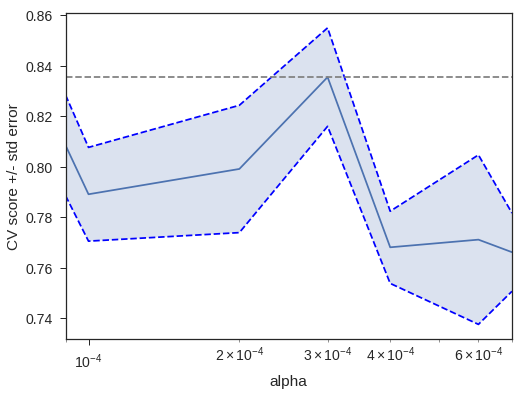

In [126]:
# We use 10-fold cross-validation to evaluate the models
alphas = [0.00009, 1e-4, 0.0002, 0.0003, 0.0004, 0.0006, 0.0007] #we get between 5 and 19 features using these values of alpha
n_folds = 5
scores = list()
scores_std = list()

for alpha in alphas:
    lasso = Lasso(alpha=alpha,fit_intercept=True, max_iter=100000, tol=0.0001)
    lasso_fit = lasso.fit(X,y)
    #print y.sum()
    #print len(y)
    cv = ShuffleSplit(n_splits=n_folds)
    this_scores = cross_val_score(lasso_fit, X, y, scoring='roc_auc', cv=cv, n_jobs=1)
    print this_scores
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

scores, scores_std = np.array(scores), np.array(scores_std)
print scores

plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

######  Selection of alpha depending on the validation score
Depending on the way the test group is picked, we have different values of alpha. 
So we test the model with three different values of alpha: [0.0001, 0.0002, 0.0003]

In [127]:
# Extract the set of relevant features and their weight, alpha = 0.0002
features_indice = list()
features_weight = list()
features = list()

for i in range (len(coef_lasso[1])):
    if coef_lasso[1][i] != 0.:
        features_indice.append(i)

print len(features_indice)

for i in range (len(all_pairoutcomes)):
    if i in features_indice:
        features.append(all_pairoutcomes[i])
        features_weight.append((all_pairoutcomes[i], coef_lasso[1][i]))
    
print len(features)
print len(features_weight)
print features[0]

24
24
24
35205185


In [128]:
# Build the new frequency tables
def make_lsd_training_table_reduced(features, pos_drugs = None, neg_drugs = None):

    # we map positive and negative drugs from their concept_code to their concept_id
    pos_drugs_mapped = list()
    for pos_drug in pos_drugs:
        pos_drugs_mapped.append(drug_mapping[pos_drug])
        
    neg_drugs_mapped = list()
    for neg_drug in neg_drugs:
        neg_drugs_mapped.append(drug_mapping[neg_drug])
        
    outcomes = np.concatenate((np.ones(len(pos_drugs),np.bool), np.zeros(len(neg_drugs),np.bool)))
    
    training_drugs = pos_drugs_mapped + neg_drugs_mapped
    
    # build the adverse events frequency table
    ae_frequencies_training = np.zeros((len(pos_drugs)+len(neg_drugs),len(features)))
    
    for r in aeolus_drugReactionCounts['results']:
        if not r['drug_concept_id'] in training_drugs:
            continue
        if not r['outcome_concept_id'] in features:
            continue
        
        
        i = training_drugs.index(r['drug_concept_id'])
        j = features.index(r['outcome_concept_id'])
        
        frequency = float(r['nreports'])/float(r['ndrugreports'])
        
        ae_frequencies_training[i,j] = frequency
                    
    return ae_frequencies_training, outcomes


# Build the frequency table for drugpairs
def make_lsd_testing_table_reduced(features):
    ae_frequencies_ddi_testing = np.zeros((len(all_drugpairs),len(features)))
    
    for r in tqdm(aeolus_drugpairReactionCounts['results']):
        
        drugpair = (r['drug1_concept_id'],r['drug2_concept_id'])
        if r['outcome_concept_id'] in features:
            x_index = all_drugpairs.index(drugpair)
            y_index = features.index(r['outcome_concept_id'])
            
            frequency = float(r['n_d1d2ae'])/float(r['n_d1d2'])
            #print frequency
            
            ae_frequencies_ddi_testing[x_index,y_index] = frequency    
                
    return ae_frequencies_ddi_testing

In [129]:
X_reduced, y_reduced = make_lsd_training_table_reduced(features, pos_controls, neg_controls)

print X_reduced.shape
print y_reduced.shape

(700, 24)
(700,)


In [130]:
X_test_reduced = make_lsd_testing_table_reduced(features)

100%|██████████| 1313184/1313184 [03:35<00:00, 6084.06it/s] 


In [131]:
print features[0]
print X_test_reduced.shape
#print X_test_reduced[2]

35205185
(39800, 24)


## Build the latent signal detection model (i.e hypertension's fingerprint)

In [132]:
# We use a Logistic Regression Binary classifier: each drug or drug pair is represented by a combination of AEs and their weight (beta coefficient)
# If a drug is above a certain threshold, we classify it as causing hypertension

def score(features_weight, X_test):
    score = list()
    
    for drugpair in X_test:
        #print drugpair
        drugpair_score = 0
        for i in range (0, len(features)):
            drugpair_score += drugpair[i] * features_weight[i][1]
        score.append(drugpair_score)
    
    return score

def y_pred_FAERS(drug_mapping):
    
    y_pred = np.zeros((len(scores)))
    pos_drugs_mapped = list()
    
    for pos_drug in pos_controls:
        if pos_drug not in drug_mapping:
            continue
        
        pos_drugs_mapped.append(drug_mapping[pos_drug])
    
    # if a drugpair has a drug known to be a positive control then we predict that the drugpair will lead to the AE
    for drugpair in all_drugpairs:         
        for drug in drugpair:
            if drug in pos_drugs_mapped:
                y_pred[all_drugpairs.index(drugpair)] = 1
                
    return y_pred

def y_pred_va():
    
    y_pred = np.zeros((len(scores)))
    
    # if a drugpair has a drug known to be a positive control then we predict that the drugpair will lead to the AE
    for drugpair in all_drugpairs:         
        if drugpair in va_omop_ddi :
            y_pred[all_drugpairs.index(drugpair)] = 1
    
    return y_pred

def predict_ddi(scores, threshold):
    
    predictions = np.zeros((len(scores)))
    for score in scores:
        if (score > threshold):
            predictions[scores.index(score)] = 1
    print sum(predictions)
    
    y_pred_Faers = y_pred_FAERS(drug_mapping)
    y_pred_VA = y_pred_va()
    
    print "Number of positive predictions from FAERS:",np.sum(y_pred_Faers)
    print "Number of positive predictions from the VA:",np.sum(y_pred_VA)
    
    print "FAERS drugpairs ROC:",roc_auc_score(y_true=y_pred_Faers,y_score=scores)
    fprFA, tprFA, _ = roc_curve(y_true=y_pred_Faers,y_score=scores)
    
    print "VA drugpairs ROC:",roc_auc_score(y_true=y_pred_VA,y_score=scores)
    fprVA, tprVA, _ = roc_curve(y_true=y_pred_VA,y_score=scores)
    
    sns.set(style='ticks', font_scale=1.4)
    
    plt.figure(figsize=(6,6))
    plt.plot(fprFA,tprFA,label='FAERS (area= %0.2f)' % auc(fprFA,tprFA))
    plt.plot(fprVA,tprVA,label='VA (area= %0.2f)' % auc(fprVA,tprVA))
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.legend(loc="lower right")
    
    sns.despine()
    
    return predictions
            

39800
5.04422031006
5484.0
Number of positive predictions from FAERS: 25994.0
Number of positive predictions from the VA: 14.0
FAERS drugpairs ROC: 0.534704952193
VA drugpairs ROC: 0.58073012043


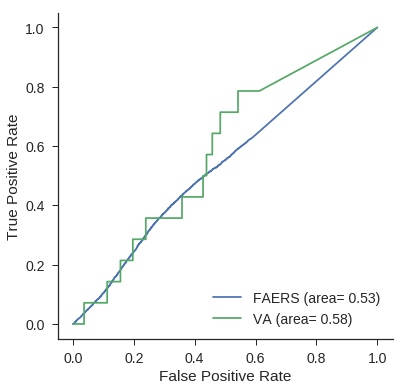

In [133]:
scores = score(features_weight, X_test_reduced)
print len(scores)
print scores[0]

threshold = 5
predictions = predict_ddi(scores, threshold)

  1%|          | 8383/1313184 [00:00<00:15, 83772.96it/s]

0.0001
13


100%|██████████| 1313184/1313184 [02:38<00:00, 8262.10it/s] 


(39800, 13)
5081.0


  0%|          | 0/1313184 [00:00<?, ?it/s]

Number of positive predictions from FAERS: 25994.0
Number of positive predictions from the VA: 14.0
FAERS drugpairs ROC: 0.534072115796
VA drugpairs ROC: 0.570525525849
0.0002
12


 31%|███       | 406743/1313184 [01:29<06:03, 2491.68it/s] 

KeyboardInterrupt: 

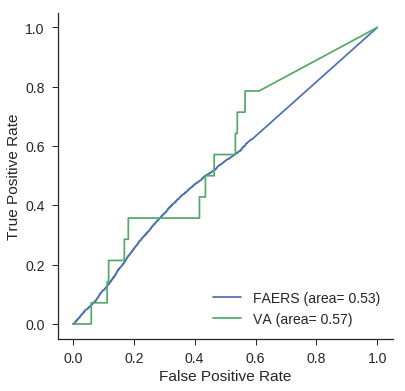

 31%|███       | 406743/1313184 [01:40<03:44, 4042.91it/s]

In [107]:
# Loop to test all three models
# We use a Logistic Regression Binary classifier: each drug or drug pair is represented by a combination of AEs and their weight (beta coefficient)
# If a drug is above a certain threshold, we classify it as causing hypertension

alphas_selected = [0.0001, 0.0002, 0.0003]
threshold = 4

for alpha in alphas_selected:
    print alpha
    
    #Extraction of features
    features_indice = list()
    features_weight = list()
    features = list()

    for i in range (len(coef_lasso[2+alphas_selected.index(alpha)])):
        if coef_lasso[2+alphas_selected.index(alpha)][i] != 0.:
            features_indice.append(i)

    for i in range (len(all_pairoutcomes)):
        if i in features_indice:
            features.append(all_pairoutcomes[i])
            features_weight.append((all_pairoutcomes[i], coef_lasso[2+alphas_selected.index(alpha)][i]))
    
    print len(features)
    
    #Construction of the new testing frequency table
    X_test_reduced = make_lsd_testing_table_reduced(features)
    print X_test_reduced.shape
    
    #Fingerprint construction
    scores = score(features_weight, X_test_reduced)
    predictions = predict_ddi(scores, threshold)


In [134]:
# Random Forest Classifier after the L1 reduction of features

def drugpair_predictions_reduced(X, y, X_test):
    
    # can't use oob after L1 regularization
    rf = RandomForestClassifier(n_estimators = 100, oob_score=False, random_state=12)
    rf.fit(X,y) #Build a forest of trees from the training set (X, y).
    
    predictions_proba = rf.predict_proba(X_test)[:,1]
    predictions = rf.predict(X_test) #predict class for X_test
    print "Mean accuracy on the given test data and labels: ", rf.score(X,y)  
    
    y_pred_Faers = y_pred_FAERS(drug_mapping)
    y_pred_VA = y_pred_va()
    
    predicted_ddi = sorted(zip(predictions_proba, all_drugpairs))
    predicted_ddi.reverse()
    i=0
    while predicted_ddi[i][0]>0.5:
        i+=1
    predicted_ddi = predicted_ddi[:i]
            
    #(i.e with at least one drug known to have hypertension as a side effect)
    print "Number of positive predictions:",np.sum(y_pred_Faers)
    
    print "FAERS drugpairs ROC:",roc_auc_score(y_true=y_pred_Faers,y_score=predictions_proba)
    fprFA, tprFA, _ = roc_curve(y_true=y_pred_Faers,y_score=predictions_proba)
    
    print "VA drugpairs ROC:",roc_auc_score(y_true=y_pred_VA,y_score=predictions_proba)
    fprVA, tprVA, _ = roc_curve(y_true=y_pred_VA,y_score=predictions_proba)

    sns.set(style='ticks', font_scale=1.4)
    
    plt.figure(figsize=(6,6))
    plt.plot(fprFA,tprFA,label='FAERS (area= %0.2f)' % auc(fprFA,tprFA))
    plt.plot(fprVA,tprVA,label='VA (area= %0.2f)' % auc(fprVA,tprVA))
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.legend(loc="lower right")
    
    sns.despine()
    
    return predicted_ddi

Mean accuracy on the given test data and labels:  0.955714285714
Number of positive predictions: 25994.0
FAERS drugpairs ROC: 0.517615661003
VA drugpairs ROC: 0.617419264494
21738


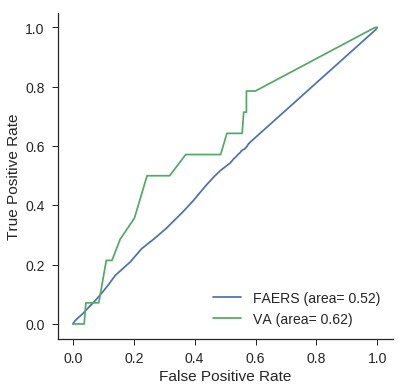

In [135]:
predicted_ddi = drugpair_predictions_reduced(X_reduced,y_reduced,X_test_reduced)
print len(predicted_ddi)

In [136]:
def drugpair_predictions(X,y,X_test):  
    
    rf = RandomForestClassifier(n_estimators = 100, oob_score=True, random_state=12)
    rf.fit(X,y) #Build a forest of trees from the training set (X, y).
    
    print "Number of estimators: ", len(rf.estimators_)
    
    predictions_proba = rf.predict_proba(X_test)[:,1]
    predictions = rf.predict(X_test) #predict class for X_test
    print "Mean accuracy on the given test data and labels: ", rf.score(X,y)   

    oob_predictions = rf.oob_decision_function_[:,1]
    oob_predictions[ np.where( np.isnan(oob_predictions) == True)[0]] = 0
    
    #roc_auc_score computes the area under the ROC curve
    print "OOB ROC:",roc_auc_score(y_true=y, y_score=oob_predictions)
    fprOOB, tprOOB, _ = roc_curve(y_true=y,y_score=oob_predictions)
    
    y_pred_Faers = y_pred_FAERS(drug_mapping)
    y_pred_VA = y_pred_va()
    
    predicted_ddi = sorted(zip(predictions_proba, all_drugpairs))
    predicted_ddi.reverse()
    i=0
    while predicted_ddi[i][0]>0.5:
        i+=1
    predicted_ddi = predicted_ddi[:i]
            
    #(i.e with at least one drug known to have hypertension as a side effect)
    print "Number of positive predictions FAERS:",np.sum(y_pred_Faers)
    print "Number of ddi predictions (with a probability > 0,5): ", len(predicted_ddi)
    
    print "FAERS drugpairs ROC:",roc_auc_score(y_true=y_pred_Faers,y_score=predictions_proba)
    fprFA, tprFA, _ = roc_curve(y_true=y_pred_Faers,y_score=predictions_proba)
    
    print "VA drugpairs ROC:",roc_auc_score(y_true=y_pred_VA,y_score=predictions_proba)
    fprVA, tprVA, _ = roc_curve(y_true=y_pred_VA,y_score=predictions_proba)
    
    sns.set(style='ticks', font_scale=1.4)
    
    plt.figure(figsize=(6,6))
    plt.plot(fprOOB,tprOOB,label='OOB (area= %0.2f)' % auc(fprOOB,tprOOB))
    plt.plot(fprFA,tprFA,label='FAERS (area= %0.2f)' % auc(fprFA,tprFA))
    plt.plot(fprVA,tprVA,label='VA (area= %0.2f)' % auc(fprVA,tprVA))
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.legend(loc="lower right")
    
    sns.despine()
    
    return predicted_ddi

Number of estimators:  100
Mean accuracy on the given test data and labels:  0.962857142857
OOB ROC: 0.822457142857
Number of positive predictions FAERS: 25994.0
Number of ddi predictions (with a probability > 0,5):  9532
FAERS drugpairs ROC: 0.51984557976
VA drugpairs ROC: 0.607293663959


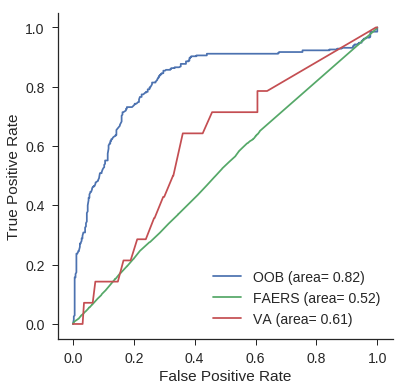

In [137]:
pred_ddi = drugpair_predictions(X,y,X_test)

## DDI predictions

In [152]:
#Treatment of the predictions
final_predictions = list()

pos_drugs_mapped = list()
for pos_drug in pos_controls:
    if pos_drug not in drug_mapping:
        continue
        
    pos_drugs_mapped.append(drug_mapping[pos_drug])

# Removing the pairs where at least one of the drugs is known to be responsible for hypertension alone
for prob, drugpair in predicted_ddi:
    if (drugpair[0] not in pos_drugs_mapped):
        if (drugpair[1] not in pos_drugs_mapped):
            # All drugpairs are twice in the list ((a,b) and (b,a)), we only keep one
            if drugpair[0] > drugpair[1]:
                final_predictions.append(drugpair)

print len(predicted_ddi)
print len(final_predictions)                
top_ddi = final_predictions[:100]
#print top_ddi

21738
3641


In [139]:
# Pull the top prediction
pair = top_ddi[0]
pair2 = top_ddi[1]
print pair
print pair2
print concept2name[pair[0]], concept2name[pair[1]]
print concept2name[pair2[0]], concept2name[pair2[1]]

(1557272, 1347384)
(1353766, 904453)
Alendronate irbesartan
Propranolol Esomeprazole


## Corroborate drugpair predictions using OHDSI data
Analysis of the top predicted DDIs.
Method: Creation of cohorts of patients using the OHDSI API.
Criteria: Patients exposed to either drug of a predicted drugpair alone and patients exposed to both within a 30 days interval.
All patients must have had their blood pressure measured within 30 days of their last drug intake. 

In [186]:
map_id_name, map_name_id = ohdsi.mapping()

In [187]:
# Retrieve patient information for the top 50 ddi predictions
qualifying_drugpairs = list()

for drugpair in tqdm(top_ddi):
    
    # Creation of the first cohort with exposure to both drugs of the drugpair within 7 days
    concept1 = ohdsi.get_concept_info(drugpair[0])
    concept2 = ohdsi.get_concept_info(drugpair[1])
    
    data = ohdsi.cohort_definition_2D(concept1, concept2)
    status = ohdsi.create_cohort(data)
    
    # Update the mapping dicionaries
    cohorts = ohdsi.get_cohorts()
    for cohort in cohorts:
        if cohort['name'] == "%s_%s"%(concept1["CONCEPT_NAME"],concept2["CONCEPT_NAME"]):
            map_id_name[cohort['id']] =  cohort['name']
            map_name_id[cohort['name']] = cohort['id']
    
    cohort_id = map_name_id["%s_%s"%(concept1["CONCEPT_NAME"],concept2["CONCEPT_NAME"])]
    info = ohdsi.generate_cohort(cohort_id)
    
    patients = ohdsi.getAlldistinctPatients(cohort_id)
    print len(patients)
    
    if(len(patients)<30):
        print "Not enough patients for cohort %s_%s" %(concept1["CONCEPT_NAME"],concept2["CONCEPT_NAME"])
        status_delete = delete_cohort(cohort_id)
    else:
        print "Enough patients for cohort %s_%s" %(concept1["CONCEPT_NAME"],concept2["CONCEPT_NAME"])
        qualifying_drugpairs.append(drugpair)

  0%|          | 0/100 [00:00<?, ?it/s]

A cohort with the same name already exists, please choose another name


  1%|          | 1/100 [00:02<04:47,  2.91s/it]

38
Enough patients for cohort Alendronate_irbesartan
A cohort with the same name already exists, please choose another name


  2%|▏         | 2/100 [00:06<05:08,  3.15s/it]

161
Enough patients for cohort Propranolol_Esomeprazole
A cohort with the same name already exists, please choose another name


  3%|▎         | 3/100 [00:10<05:26,  3.37s/it]

11
Not enough patients for cohort Calcium Carbonate_Loratadine
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


  4%|▍         | 4/100 [00:13<05:08,  3.21s/it]

1
Not enough patients for cohort Vitamin D_ezetimibe
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


  5%|▌         | 5/100 [00:16<04:59,  3.15s/it]

8
Not enough patients for cohort Loratadine_duloxetine
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


  6%|▌         | 6/100 [00:19<04:58,  3.18s/it]

50
Enough patients for cohort Glyburide_montelukast
A cohort with the same name already exists, please choose another name


  7%|▋         | 7/100 [00:22<04:52,  3.14s/it]

27
Not enough patients for cohort Bisoprolol_Clonazepam
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


  8%|▊         | 8/100 [00:25<04:51,  3.17s/it]

284
Enough patients for cohort Amoxicillin_Nifedipine
A cohort with the same name already exists, please choose another name


  9%|▉         | 9/100 [00:29<04:57,  3.27s/it]

130
Enough patients for cohort Glyburide_Clonazepam
A cohort with the same name already exists, please choose another name


 10%|█         | 10/100 [00:33<05:14,  3.49s/it]

46
Enough patients for cohort Alendronate_Ramipril
A cohort with the same name already exists, please choose another name


 11%|█         | 11/100 [00:36<04:57,  3.35s/it]

1
Not enough patients for cohort onabotulinumtoxinA_Alprazolam
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 12%|█▏        | 12/100 [00:39<04:59,  3.41s/it]

0
Not enough patients for cohort Multivitamin preparation_erlotinib
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 13%|█▎        | 13/100 [00:44<05:19,  3.67s/it]

0
Not enough patients for cohort Multivitamin preparation_Isotretinoin
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 14%|█▍        | 14/100 [00:46<04:48,  3.36s/it]

2
Not enough patients for cohort Ascorbic Acid_Alendronate
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 15%|█▌        | 15/100 [00:50<04:56,  3.48s/it]

14
Not enough patients for cohort Fluconazole_mesalamine
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 16%|█▌        | 16/100 [00:54<04:49,  3.45s/it]

0
Not enough patients for cohort peginterferon alfa-2a_Furosemide
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 17%|█▋        | 17/100 [00:57<04:41,  3.39s/it]

31
Enough patients for cohort Alendronate_Estrogens, Conjugated (USP)
A cohort with the same name already exists, please choose another name


 18%|█▊        | 18/100 [01:00<04:40,  3.42s/it]

119
Enough patients for cohort Alendronate_Enalapril
A cohort with the same name already exists, please choose another name


 19%|█▉        | 19/100 [01:04<04:40,  3.47s/it]

232
Enough patients for cohort Fenofibrate_Verapamil
A cohort with the same name already exists, please choose another name


 20%|██        | 20/100 [01:08<04:54,  3.68s/it]

2
Not enough patients for cohort Insulin Lispro_Estrogens, Conjugated (USP)
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 21%|██        | 21/100 [01:11<04:28,  3.41s/it]

2
Not enough patients for cohort Estrogens, Conjugated (USP)_tiotropium
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 22%|██▏       | 22/100 [01:15<04:33,  3.51s/it]

61
Enough patients for cohort ezetimibe_Nitroglycerin
A cohort with the same name already exists, please choose another name


 23%|██▎       | 23/100 [01:18<04:23,  3.42s/it]

30
Enough patients for cohort levothyroxine_bevacizumab
A cohort with the same name already exists, please choose another name


 24%|██▍       | 24/100 [01:21<04:22,  3.46s/it]

32
Enough patients for cohort levothyroxine_Paclitaxel
A cohort with the same name already exists, please choose another name


 25%|██▌       | 25/100 [01:25<04:18,  3.45s/it]

42
Enough patients for cohort candesartan_Diazepam
A cohort with the same name already exists, please choose another name


 26%|██▌       | 26/100 [01:28<04:15,  3.45s/it]

39
Enough patients for cohort Nifedipine_Methotrexate
A cohort with the same name already exists, please choose another name


 27%|██▋       | 27/100 [01:32<04:13,  3.47s/it]

50
Enough patients for cohort Nifedipine_duloxetine
A cohort with the same name already exists, please choose another name


 28%|██▊       | 28/100 [01:35<04:12,  3.51s/it]

206
Enough patients for cohort Verapamil_Oxycodone
A cohort with the same name already exists, please choose another name


 29%|██▉       | 29/100 [01:39<04:09,  3.51s/it]

1
Not enough patients for cohort onabotulinumtoxinA_Aspirin
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 30%|███       | 30/100 [01:42<04:03,  3.48s/it]

0
Not enough patients for cohort Calcium Carbonate_Interferon beta-1a
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 31%|███       | 31/100 [01:46<04:00,  3.49s/it]

1
Not enough patients for cohort peginterferon alfa-2b_Clonazepam
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 32%|███▏      | 32/100 [01:50<04:12,  3.72s/it]

8
Not enough patients for cohort Estrogens, Conjugated (USP)_Methadone
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 33%|███▎      | 33/100 [01:53<03:53,  3.49s/it]

213
Enough patients for cohort Estradiol_Enalapril
A cohort with the same name already exists, please choose another name


 34%|███▍      | 34/100 [01:57<03:54,  3.55s/it]

3
Not enough patients for cohort Leuprolide_Alprazolam
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 35%|███▌      | 35/100 [02:00<03:41,  3.40s/it]

0
Not enough patients for cohort irbesartan_Interferon beta-1a
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 36%|███▌      | 36/100 [02:03<03:38,  3.41s/it]

77
Enough patients for cohort Bisoprolol_Ranitidine
A cohort with the same name already exists, please choose another name


 37%|███▋      | 37/100 [02:07<03:47,  3.62s/it]

4
Not enough patients for cohort sildenafil_Valproate
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 38%|███▊      | 38/100 [02:10<03:32,  3.43s/it]

0
Not enough patients for cohort Isotretinoin_Escitalopram
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 39%|███▉      | 39/100 [02:14<03:34,  3.52s/it]

3
Not enough patients for cohort Furosemide_natalizumab
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 40%|████      | 40/100 [02:18<03:33,  3.56s/it]

5
Not enough patients for cohort Sodium Oxybate_Valproate
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 41%|████      | 41/100 [02:24<04:22,  4.45s/it]

0
Not enough patients for cohort Calcium_Levetiracetam
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 42%|████▏     | 42/100 [02:27<03:51,  3.99s/it]

232
Enough patients for cohort Glyburide_Spironolactone
A cohort with the same name already exists, please choose another name


 43%|████▎     | 43/100 [02:30<03:29,  3.67s/it]

141
Enough patients for cohort Glyburide_Esomeprazole
A cohort with the same name already exists, please choose another name


 44%|████▍     | 44/100 [02:33<03:13,  3.45s/it]

159
Enough patients for cohort Glyburide_Alprazolam
A cohort with the same name already exists, please choose another name


 45%|████▌     | 45/100 [02:36<03:05,  3.37s/it]

45
Enough patients for cohort Glyburide_duloxetine
A cohort with the same name already exists, please choose another name


 46%|████▌     | 46/100 [02:40<03:15,  3.62s/it]

71
Enough patients for cohort Fenofibrate_Clonazepam
A cohort with the same name already exists, please choose another name


 47%|████▋     | 47/100 [02:44<03:19,  3.77s/it]

119
Enough patients for cohort Estrogens, Conjugated (USP)_Diltiazem
A cohort with the same name already exists, please choose another name


 48%|████▊     | 48/100 [02:47<02:57,  3.42s/it]

50
Enough patients for cohort Clonidine_Losartan
A cohort with the same name already exists, please choose another name


 49%|████▉     | 49/100 [02:50<02:50,  3.35s/it]

60
Enough patients for cohort bevacizumab_Paclitaxel
A cohort with the same name already exists, please choose another name


 50%|█████     | 50/100 [02:54<02:53,  3.47s/it]

0
Not enough patients for cohort erlotinib_Oxycodone
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 51%|█████     | 51/100 [02:57<02:45,  3.38s/it]

0
Not enough patients for cohort Nifedipine_Amiodarone
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 52%|█████▏    | 52/100 [03:01<02:44,  3.43s/it]

0
Not enough patients for cohort Methotrexate_mesalamine
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 53%|█████▎    | 53/100 [03:05<02:47,  3.57s/it]

0
Not enough patients for cohort tiotropium_Ranitidine
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 54%|█████▍    | 54/100 [03:08<02:36,  3.40s/it]

0
Not enough patients for cohort tamsulosin_duloxetine
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 55%|█████▌    | 55/100 [03:12<02:47,  3.72s/it]

0
Not enough patients for cohort dabigatran etexilate_olmesartan
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 56%|█████▌    | 56/100 [03:15<02:38,  3.61s/it]

0
Not enough patients for cohort dabigatran etexilate_candesartan
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 57%|█████▋    | 57/100 [03:19<02:34,  3.60s/it]

0
Not enough patients for cohort dabigatran etexilate_Bisoprolol
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 58%|█████▊    | 58/100 [03:22<02:27,  3.52s/it]

0
Not enough patients for cohort Calcium Chloride / Glucose / Lactate / Magnesium Chloride / Sodium Chloride Intraperitoneal Solution_Potassium Chloride
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 59%|█████▉    | 59/100 [03:26<02:30,  3.66s/it]

0
Not enough patients for cohort Calcium Chloride / Glucose / Lactate / Magnesium Chloride / Sodium Chloride Intraperitoneal Solution_atorvastatin
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 60%|██████    | 60/100 [03:30<02:28,  3.71s/it]

0
Not enough patients for cohort Calcium Chloride / Glucose / Lactate / Magnesium Chloride / Sodium Chloride Intraperitoneal Solution_carvedilol
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 61%|██████    | 61/100 [03:33<02:17,  3.53s/it]

0
Not enough patients for cohort Insulin_Etanercept
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 62%|██████▏   | 62/100 [03:38<02:27,  3.87s/it]

0
Not enough patients for cohort Calcium Carbonate_Niacin
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 63%|██████▎   | 63/100 [03:41<02:16,  3.70s/it]

0
Not enough patients for cohort Calcium Carbonate_Enalapril
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 64%|██████▍   | 64/100 [03:45<02:19,  3.86s/it]

0
Not enough patients for cohort Calcium_mycophenolate mofetil
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 65%|██████▌   | 65/100 [03:48<02:05,  3.60s/it]

0
Not enough patients for cohort Cyclosporine_Ranitidine
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 66%|██████▌   | 66/100 [03:52<02:00,  3.55s/it]

0
Not enough patients for cohort mycophenolate mofetil_Famotidine
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 67%|██████▋   | 67/100 [03:55<01:57,  3.55s/it]

0
Not enough patients for cohort Sulfamethoxazole_Alprazolam
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 68%|██████▊   | 68/100 [03:59<01:52,  3.51s/it]

0
Not enough patients for cohort Alendronate_Amiodarone
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 69%|██████▉   | 69/100 [04:03<01:53,  3.65s/it]

0
Not enough patients for cohort Insulin Lispro_tiotropium
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 70%|███████   | 70/100 [04:06<01:48,  3.62s/it]

0
Not enough patients for cohort Insulin Lispro_Ranitidine
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 71%|███████   | 71/100 [04:11<01:55,  3.97s/it]

0
Not enough patients for cohort Estrogens, Conjugated (USP)_infliximab
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 72%|███████▏  | 72/100 [04:14<01:44,  3.74s/it]

0
Not enough patients for cohort atorvastatin_Cisplatin
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 73%|███████▎  | 73/100 [04:18<01:43,  3.85s/it]

0
Not enough patients for cohort Simvastatin_Levetiracetam
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 74%|███████▍  | 74/100 [04:22<01:37,  3.77s/it]

0
Not enough patients for cohort Teriparatide_duloxetine
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 75%|███████▌  | 75/100 [04:26<01:37,  3.89s/it]

0
Not enough patients for cohort Niacin_Methotrexate
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name
0
Not enough patients for cohort Niacin_Docusate


 76%|███████▌  | 76/100 [04:32<01:50,  4.61s/it]

Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 77%|███████▋  | 77/100 [04:36<01:36,  4.21s/it]

0
Not enough patients for cohort Clonidine_duloxetine
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 78%|███████▊  | 78/100 [04:39<01:24,  3.84s/it]

0
Not enough patients for cohort Ramipril_Verapamil
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 79%|███████▉  | 79/100 [04:42<01:20,  3.82s/it]

0
Not enough patients for cohort Digoxin_bosentan
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 80%|████████  | 80/100 [04:46<01:17,  3.86s/it]

0
Not enough patients for cohort Warfarin_infliximab
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 81%|████████  | 81/100 [04:51<01:18,  4.15s/it]

0
Not enough patients for cohort Verapamil_Valproate
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 82%|████████▏ | 82/100 [04:55<01:11,  3.99s/it]

0
Not enough patients for cohort montelukast_Docusate
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 83%|████████▎ | 83/100 [04:58<01:02,  3.68s/it]

0
Not enough patients for cohort fexofenadine_Valproate
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 84%|████████▍ | 84/100 [05:01<00:58,  3.64s/it]

0
Not enough patients for cohort telaprevir_Losartan
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 85%|████████▌ | 85/100 [05:04<00:52,  3.47s/it]

0
Not enough patients for cohort telaprevir_Propranolol
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 86%|████████▌ | 86/100 [05:09<00:52,  3.76s/it]

0
Not enough patients for cohort telaprevir_valsartan
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 87%|████████▋ | 87/100 [05:13<00:50,  3.88s/it]

0
Not enough patients for cohort telaprevir_Albuterol
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 88%|████████▊ | 88/100 [05:17<00:46,  3.84s/it]

0
Not enough patients for cohort telaprevir_Promethazine
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 89%|████████▉ | 89/100 [05:20<00:39,  3.58s/it]

0
Not enough patients for cohort telaprevir_Oxycodone
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 90%|█████████ | 90/100 [05:23<00:34,  3.45s/it]

0
Not enough patients for cohort telaprevir_Ondansetron
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 91%|█████████ | 91/100 [05:26<00:31,  3.46s/it]

0
Not enough patients for cohort telaprevir_Spironolactone
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 92%|█████████▏| 92/100 [05:29<00:26,  3.31s/it]

0
Not enough patients for cohort telaprevir_Ranitidine
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 93%|█████████▎| 93/100 [05:33<00:23,  3.42s/it]

0
Not enough patients for cohort telaprevir_Clonazepam
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 94%|█████████▍| 94/100 [05:37<00:20,  3.44s/it]

0
Not enough patients for cohort dabigatran etexilate_Ascorbic Acid
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 95%|█████████▌| 95/100 [05:40<00:16,  3.39s/it]

0
Not enough patients for cohort olmesartan_Sodium Oxybate
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 96%|█████████▌| 96/100 [05:43<00:13,  3.26s/it]

0
Not enough patients for cohort fingolimod_Ascorbic Acid
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 97%|█████████▋| 97/100 [05:46<00:10,  3.34s/it]

0
Not enough patients for cohort fingolimod_Simvastatin
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 98%|█████████▊| 98/100 [05:50<00:06,  3.37s/it]

0
Not enough patients for cohort onabotulinumtoxinA_Metoprolol
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


 99%|█████████▉| 99/100 [05:53<00:03,  3.46s/it]

0
Not enough patients for cohort Insulin_bevacizumab
Cohort was deleted with exit status 204 
A cohort with the same name already exists, please choose another name


100%|██████████| 100/100 [05:57<00:00,  3.55s/it]

0
Not enough patients for cohort Potassium Chloride_erlotinib
Cohort was deleted with exit status 204 


In [188]:
print len(qualifying_drugpairs)
print qualifying_drugpairs
#print concept2name[qualifying_drugpairs[0][0]], concept2name[qualifying_drugpairs[0][1]]
#print concept2name[qualifying_drugpairs[1][0]], concept2name[qualifying_drugpairs[1][1]]
#print concept2name[qualifying_drugpairs[2][0]], concept2name[qualifying_drugpairs[2][1]]

26
[(1557272, 1347384), (1353766, 904453), (1559684, 1154161), (1713332, 1318853), (1559684, 798874), (1557272, 1334456), (1557272, 1549080), (1557272, 1341927), (1551803, 1307863), (1526475, 1361711), (1501700, 1397141), (1501700, 1378382), (1351557, 723013), (1318853, 1305058), (1318853, 715259), (1307863, 1124957), (1548195, 1341927), (1338005, 961047), (1559684, 970250), (1559684, 904453), (1559684, 781039), (1559684, 715259), (1551803, 798874), (1549080, 1328165), (1398937, 1367500), (1397141, 1378382)]


In [68]:
# Assess significance of the difference in values of BP for drugpair and control groups using Mann-Whitney U test
from scipy.stats import mannwhitneyu

In [69]:
# Correct for multiple hypothesis testing using Bonferroni's method